In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from help_functions import collect_config_to_df, plot_common, plot_comparing_models, get_same_diff_df, show_plots, vizulaize_chunked, create_movie, plot_veff, plot_chunked_veff, get_model_config
import numpy as np
from scipy.stats import chi2_contingency, norm
from scipy.optimize import curve_fit
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from itertools import combinations
import itertools
from matplotlib import cm
import yaml





In [2]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))


In [3]:
def chi_square_tests(df, target):
    for column in df.columns:
        if column != target:
            contingency_table = pd.crosstab(df[column], df[target])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"Chi-square test for {column} and {target}:")
            print(f"Chi-square statistic = {chi2}")
            print(f"p-value = {p}\n")

In [2]:
exclude_columns_comparing =    ['encoder_param',
                                'num_param',
                                'final_param',
                                'input_param',
                                'max_relative_position', 
                                'pos_param',
                                'training_time',
                                'MACs',
                                'NSE_AT_10KNRF',
                                #'model_num',
                                'encoder_type',
                                'batch_size',
                                #'FLOPs',
                                #'Veff avg.'
                                ]

In [3]:
exclude_columns_common = [
    'activation',
    #'batch_size',
    'decreas_factor',
    'dropout',
    #'embed_type',
    'encoder_param',
    'encoder_type',
    'final_param',
    'final_type',
    'input_param',
    'num_param',
    'learning_rate',
    'location',
    'loss_function',
    'max_relative_position',
    'n_ant',
    'normalization',
    'pos_enc_type',
    'pos_param',
    'residual_type',
    # 'seq_len',
    'step_size',
    'encoder_type',
    'training_time',
    'MACs',
    'NSE_AT_10KNRF',
    'max_pool',
    'FLOP',
    'step_size',
    'learning_rate',
    'projection_type',
    'seq_len',
    'embed_type',

]

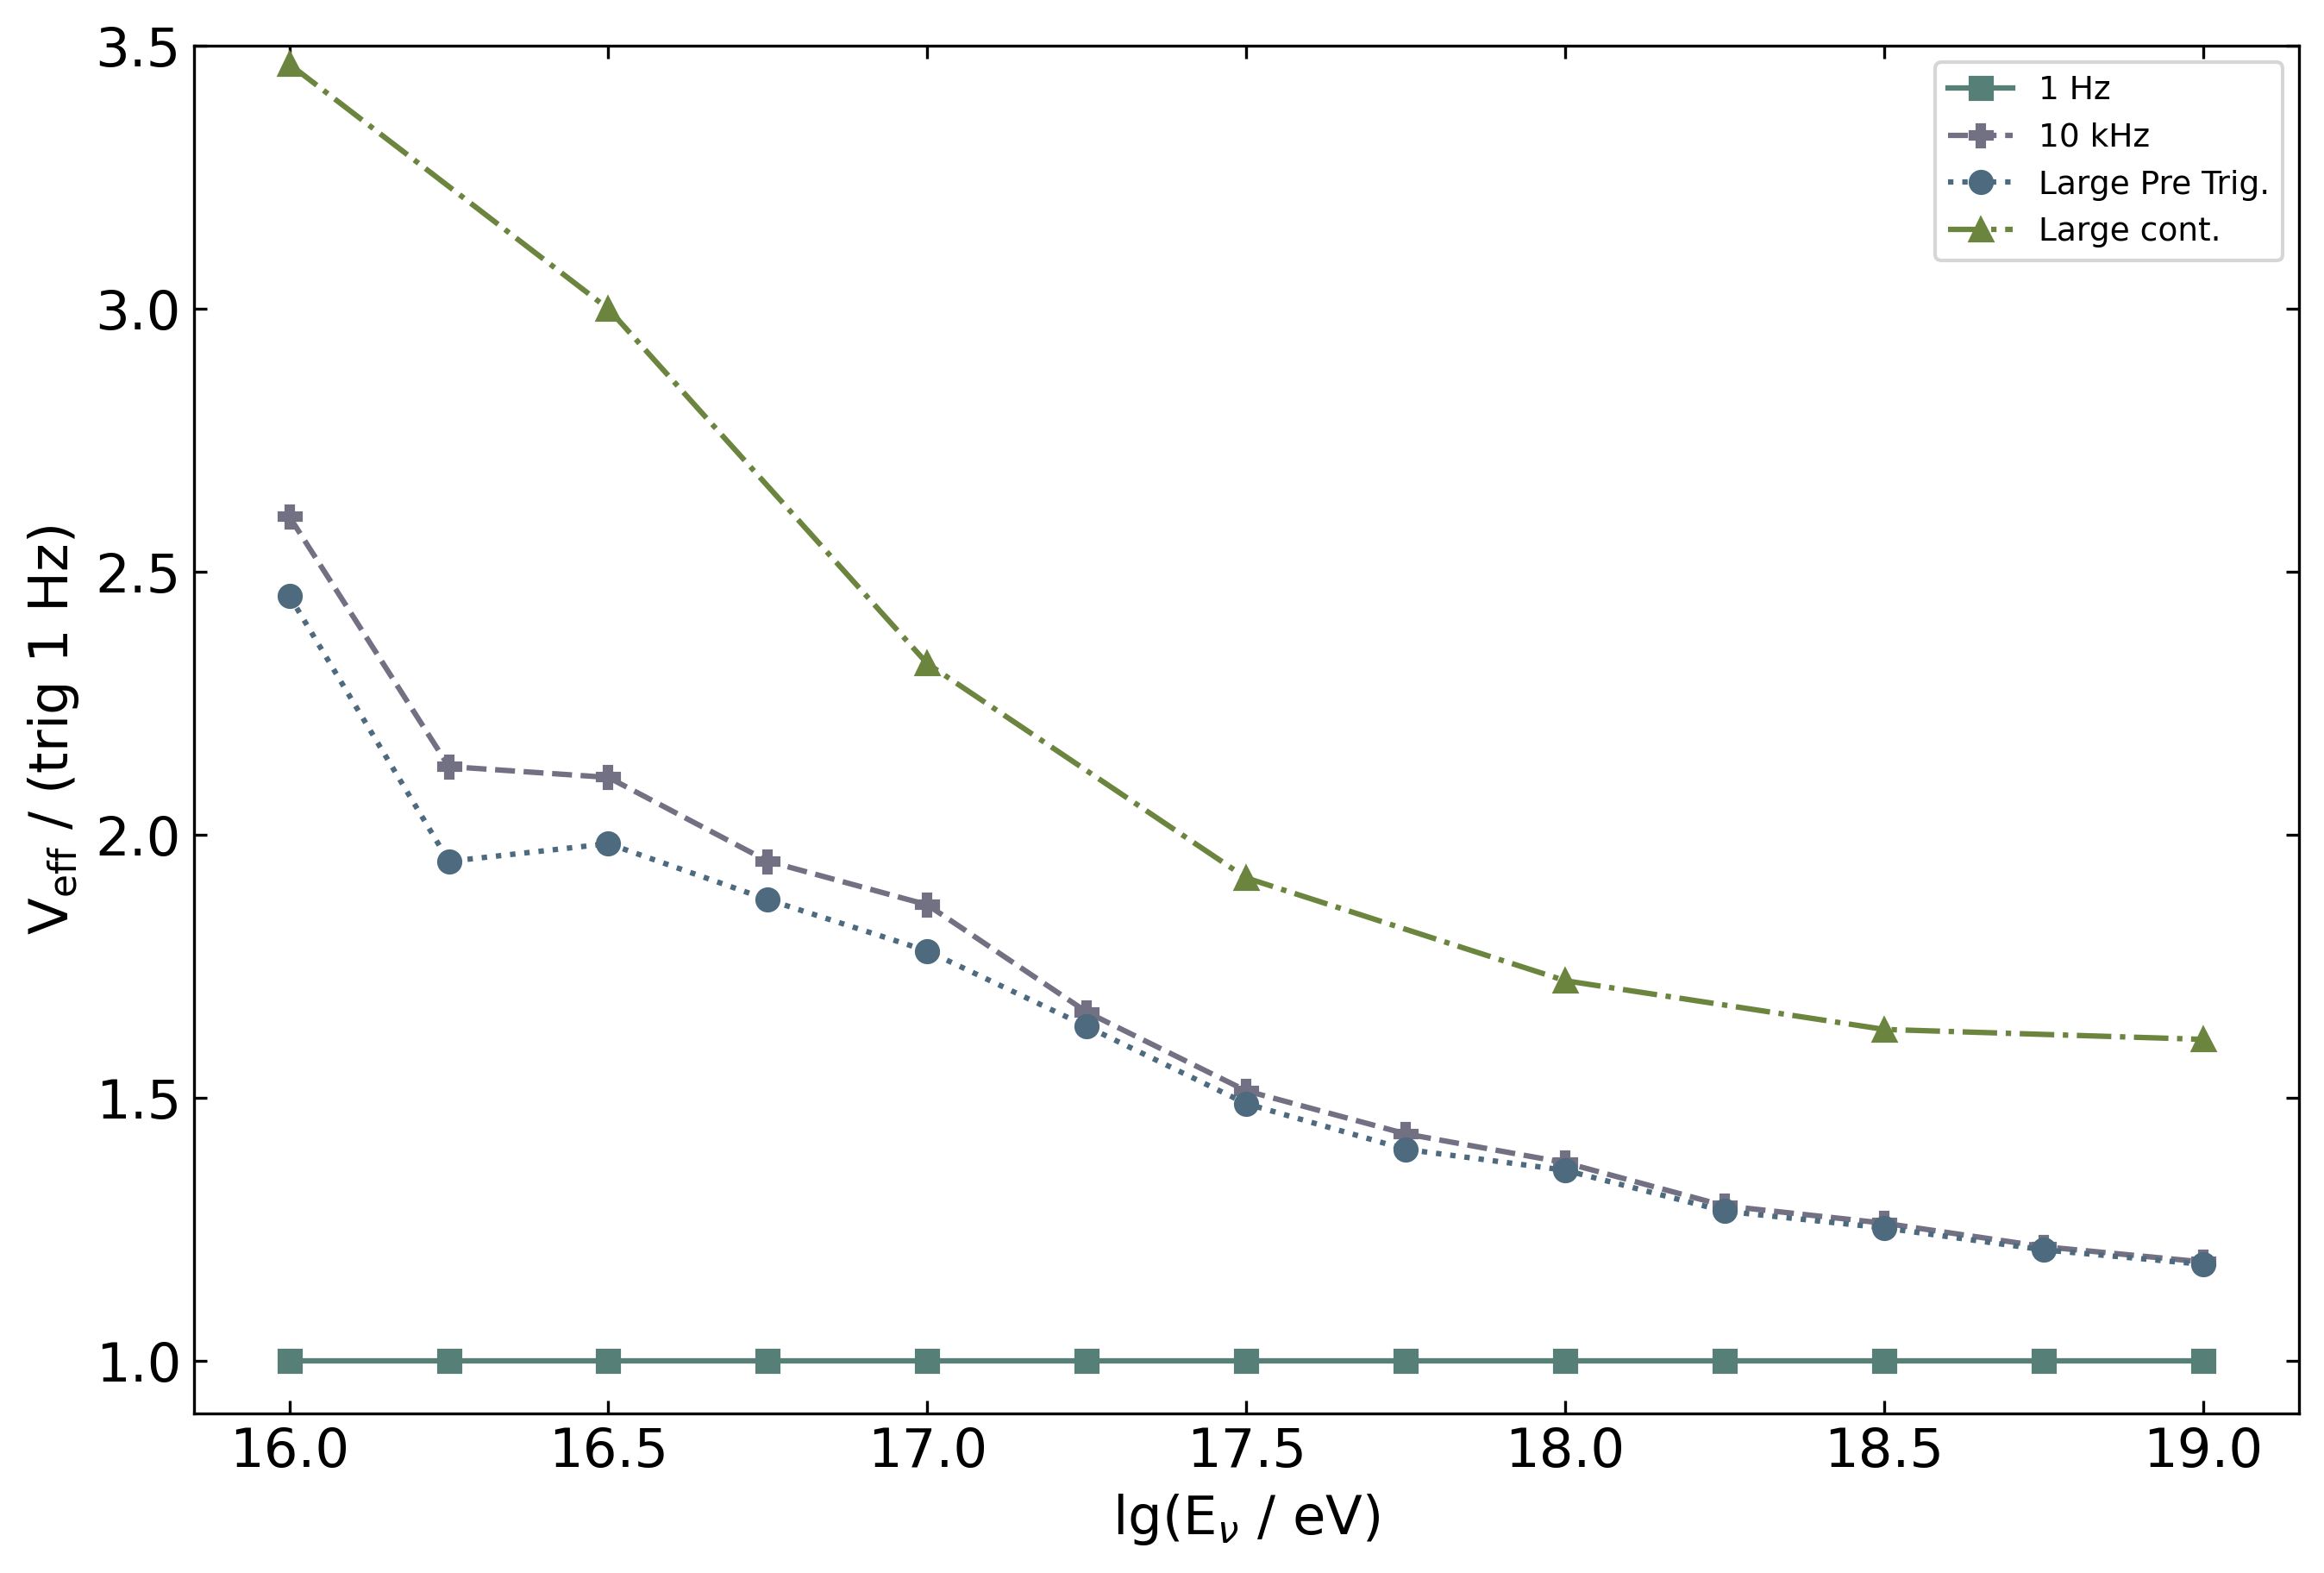

    Model      16.0     16.25      16.5     16.75      17.0     17.25  \
0    1 Hz  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  10 kHz  2.604873  2.129681  2.109074  1.949571  1.866780  1.662805   
2     256  2.454380  1.949412  1.983090  1.876569  1.779109  1.635519   
3    trig  3.465265  3.000059  2.325488  1.917897  1.722478  1.629827   

       17.5     17.75      18.0     18.25      18.5     18.75      19.0  \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  1.513082  1.431264  1.376417  1.294384  1.261389  1.216725  1.187666   
2  1.488552  1.401834  1.362061  1.284139  1.252423  1.210667  1.183130   
3  1.610929       NaN       NaN       NaN       NaN       NaN       NaN   

    Average  
0  1.000000  
1  1.661824  
2  1.604684  
3  2.238849  


In [4]:

models =  [256]

alternative_labels = ['Large Pre Trig.','Large cont.']# '316 004 rolls 300', '316 best rolls 0', '316 best rolls 300', '316 last rolls 0', '316 last rolls 300']#['1','2','3','4', 'Prev. CNN'] #['Seq. length 128', 'Seq. length 64']#None#['FLOPs: 48.4 M', 'FLOPs: 11.0 M', 'FLOPs: 2.6 M', 'FLOPs: 0.6 M', 'FLOPs: 0.1 M']

reference_models = [

                    ##########################################################################################################
                    # LPDA models                                                                                            #
                    ##########################################################################################################
                    # '/home/halin/Master/Transformer/figures/veff/Chunked Transformer LPDA 301.npz',               # Chunked Transformer
                    # '/home/halin/Master/Transformer/figures/veff/Chunked Transformer LPDA 302.npz',               # Chunked Transformer
                    # '/home/halin/Master/Transformer/figures/veff/Chunked Transformer LPDA 303.npz',               # Chunked Transformer
                    # '/home/halin/Master/Transformer/figures/veff/Chunked Transformer LPDA 311.npz',               # Chunked Transformer
    
                    # '/home/halin/Master/Transformer/figures/veff/Transformer Chunked 316 004 rolls 0.npz',       # Chunked Transformer
                    # '/home/halin/Master/Transformer/figures/veff/Transformer Chunked 316 004 rolls 300.npz',     # Chunked Transformer
                    # '/home/halin/Master/Transformer/figures/veff/Transformer Chunked 316 best rolls 0.npz',       # Chunked Transformer
                    # '/home/halin/Master/Transformer/figures/veff/Transformer Chunked 316 best rolls 300.npz',     # Chunked Transformer
                    # '/home/halin/Master/Transformer/figures/veff/Transformer Chunked 316 last rolls 0.npz',       # Chunked Transformer
                    #'/home/halin/Master/Transformer/figures/veff/Transformer Chunked 316 last rolls 300.npz',     # Chunked Transformer
                    '/home/halin/Master/Transformer/figures/veff/Transformer Chunked 316 last rolls 105.npz',     # Chunked Transformer'


                    ##########################################################################################################
                    # Phased models                                                                                          #
                    ##########################################################################################################
                    # '/home/halin/Master/Transformer/figures/veff/Transformer Chunked 710 040 rolls 300.npz',     # Chunked Transformer phased
                    # '/home/halin/Master/Transformer/figures/veff/Transformer Chunked 711 last rolls 300.npz',     # Chunked Transformer phased
                    
                    # '/home/halin/Master/Transformer/figures/veff/transformer 700 phased chunked.npz',             # Chunked Transformer phased
                    # '/home/halin/Master/Transformer/figures/veff/transformer 701 phased chunked.npz',             # Chunked Transformer phased
                    # '/home/halin/Master/Transformer/figures/veff/transformer 702 phased chunked.npz',             # Chunked Transformer phased
                    #   '/home/halin/Master/Transformer/figures/veff/2 layer CNN w hidden phased.npz',           # Chunked phased
                    #   '/home/halin/Master/Transformer/figures/veff/1 layer CNN (30 filts) wo hidden phased.npz', # Chunked phased 1.1 M FLOPs
                    # '/home/halin/Master/Transformer/figures/veff/Chunked LPDA.npz',                     # Chunked LPDA
                    #'/home/halin/Master/Transformer/figures/veff/Pre-trig. 37k calc.npz',                 # Pre-trig LPDA
                    #'/home/halin/Master/Transformer/figures/veff/Pre-trig. 9k calc.npz'                   # Pre-trig LPDA    
                     #'/home/halin/Master/Transformer/figures/veff/Pre-trig. (9 filts) 71k calc.npz',   #  Pre-trig phased
                    #'/home/halin/Master/Transformer/figures/veff/Pre-trig. (5 filts) 13k calc.npz',       # Pre-trig phased
                    # '/home/halin/Master/Transformer/figures/veff/Pre-trig. (5 filts) 5k calc.npz'        # Pre-trig phased
                        ]
veff_files = []
try:
    for model in models:
        veff_files.append(f'/mnt/md0/halin/Models/model_{model}/plot/QuickVeffRatio_{model}_best.npz')
except:
    pass
veff_files += reference_models
results = plot_veff(veff_files, plot_path='', y_max=3.5, alt_labels=alternative_labels)
print(results)
# Assuming 'Model number' is the column containing ['1 Hz'] and ['10 kHz']
excluded_values = ['1 Hz', '10 kHz']

# Create a new DataFrame excluding the specified values
model_results = results[~results['Model'].isin(excluded_values)]

models = np.array(model_results['Model'].values)
values = np.array(model_results['Average'].values)




/software/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


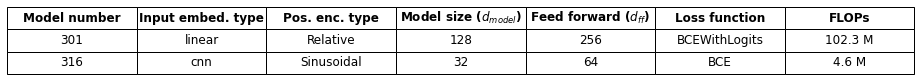

   model_num embed_type pos_enc_type  d_model  d_ff  loss_function      FLOPs
0        301     linear     Relative      128   256  BCEWithLogits  102269313
0        316        cnn   Sinusoidal       32    64            BCE    4587617
   max_pool projection_type              final_type residual_type  \
0       NaN             NaN  d_model_average_linear        pre_ln   
0       1.0          linear  d_model_average_linear        pre_ln   

  normalization activation  N  h  n_ant  seq_len  batch_size  learning_rate  \
0         layer       relu  2  4      4      256        1024          0.001   
0         layer       relu  2  4      4      256        1024          0.001   

   step_size  decreas_factor  dropout  pos_param  NSE_AT_10KNRF  training_time  
0          7             0.7        0          0              0              0  
0          7             0.7        0          0              0              0  
[301, 316]


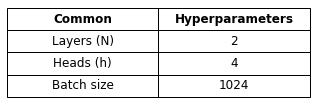

In [13]:
#modelses = [[1250,1251,1252,1253,1254,1255,1256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273]]
#modelses = [[263,266]]
#modelses = [[700,701,702,703,704,705,706,707]]
#modelses = [[301,302,303,311]]
#modelses = [list(range(280,296))]
#modelses = [[609,610,611,612,613]]
# modelses = [[500,501,502,503,504,505,506,507]]
# modelses = [list(range(508,520))] + modelses
#modeleses = [list(range(320,328))]
modelses = [[301,316]]


if 300 <= modelses[0][0] < 400 or 700 <= modelses[0][0] < 800:
    model_path = '/home/halin/Master/nuradio-analysis/configs/chunked/'
else:
    model_path = '/mnt/md0/halin/Models/'


alternative_labels = []
for model in modelses[0]:
    config = get_model_config(model, model_path)
    N = config['transformer']['architecture']['N']
    h = config['transformer']['architecture']['h']
    d_ff = config['transformer']['architecture']['d_ff']
    d_model = config['transformer']['architecture']['d_model']
    alt_label = f'$N$ = {N}, $d_{{model}}$ = {d_model}, $d_{{ff}}$ = {d_ff}'
    alternative_labels.append(alt_label)
sort = False
col_width = 3.0
save = False
prefix = ''
for models in modelses:

    if sort:
        veff_files = []
        for model in models:
            veff_files.append(f'/mnt/md0/halin/Models/model_{model}/plot/QuickVeffRatio_{model}_best.npz')

        results = plot_veff(veff_files, plot_path='', y_max=2.5, alt_labels=alternative_labels)

        # Assuming 'Model number' is the column containing ['1 Hz'] and ['10 kHz']
        excluded_values = ['1 Hz', '10 kHz']

        # Create a new DataFrame excluding the specified values
        model_results = results[~results['Model'].isin(excluded_values)]


        models = np.array(model_results['Model'].values)
        values = np.array(model_results['Average'].values)

        sorted_index = np.argsort(values)

        models = models[sorted_index]
        values = values[sorted_index]

    df = collect_config_to_df(models, model_path=model_path, type_of_file='yaml')
    
    if sort:
        df['Veff avg.'] = values
        print(values)



    df_same, df_diff = get_same_diff_df(df)
    

    df_comp = plot_comparing_models(df_diff, 
                          row_height=0.35, 
                          col_width=3.0, 
                          sort=sort, 
                          exclude_columns=exclude_columns_comparing, 
                          save=save,
                          prefix=prefix,
                          )
    print(df_comp)
    print(df_same)
    print(models)

    try:
        plot_common(df_same.iloc[[0]] , 
                row_height=0.4, 
                col_width=col_width + 0.5, 
                exclude_columns=exclude_columns_common, 
                save=save,
                prefix=prefix,
                )
    except:
        pass

    





In [ ]:
# Select the columns to normalize
cols_to_normalize = ['N', 'd_model', 'd_ff']
df_copy_2 = df.copy()

# Normalize the values in each row
df_copy_2[cols_to_normalize] = df_copy_2[cols_to_normalize].div(df_copy_2[cols_to_normalize].sum(axis=1), axis=0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df_copy_2['N'], df_copy_2['d_model'], df_copy_2['d_ff'], c=df_copy_2['Veff avg.'])
ax.set_xlabel('N')
ax.set_ylabel('d_model')
ax.set_zlabel('d_ff')
plt.colorbar(sc, label='Veff avg.')
plt.show()
print(df_copy_2)

first_split_index = len(df_copy_2) // 3

# Compute the average over the upper half of the DataFrame
upper_third = df_copy_2.iloc[:first_split_index].mean()

midel_split_index = len(df_copy_2) // 3 * 2
middel_third = df_copy_2.iloc[first_split_index:midel_split_index].mean()

# Compute the average over the lower half of the DataFrame
lower_third = df_copy_2.iloc[midel_split_index:].mean()

print('Average over the upper third:\n', upper_third)
print('Average over the lower third:\n', middel_third)
print('Average over the lower third:\n', lower_third)

# Groupe results

N =       4:  Average Veff =  1.35,Average FLOPs = 105.0 M, Total points =    17, and is the best 1 times out of 4,
N =       2:  Average Veff =  1.34,Average FLOPs = 52.6 M, Total points =    19, and is the best 1 times out of 4,
Standard deviation of the sample mean: 0.01
Total number of points = 36.0, Total number of points = 36.0
N            0.077691
d_model      0.548155
d_ff         0.393481
Veff avg.    1.000000
Name: Veff avg., dtype: float64
Mann Whitney U test between 4 and 2: test statistic 7.0, p-value 0.44261695723660077


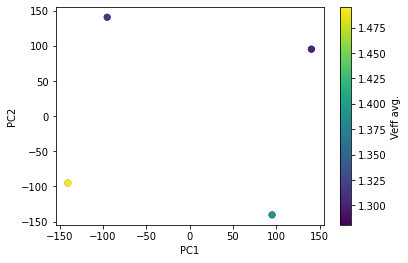

In [6]:
hyper_parameter = 'N'
all_hyper_parameters = ['N',  'd_model',  'd_ff']

significance = 0.02
signigicance_procentage = 0.05
# hyper_parameter = 'N'
# all_hyper_parameters = ['d_model', 'N', 'h', 'd_ff']
exclusive_hyper_parameters = [param for param in all_hyper_parameters if param != hyper_parameter]

df_diff_copy = df_diff.copy()
df_diff_copy['Points'] = df_diff_copy['Veff avg.'].rank(ascending=True)
unique_values = df_diff_copy[hyper_parameter].unique()

df_diff_copy = df_diff_copy.reset_index(drop=True)

grouped_df = df_diff_copy.groupby(all_hyper_parameters)['Veff avg.'].mean().reset_index()
#print(grouped_df)
unique_combinations = grouped_df[exclusive_hyper_parameters].drop_duplicates().values

total_number_of_points = 0


result_list = {}

for value in unique_values:
    total_points = df_diff_copy[df_diff_copy[hyper_parameter] == value]['Points'].sum()
    veff_avg = df_diff_copy[df_diff_copy[hyper_parameter] == value]['Veff avg.'].mean()

    result_list[value] = df_diff_copy[df_diff_copy[hyper_parameter] == value]['Points']

    avg_flops = []


    best_count = 0

    for combination in unique_combinations:

        condition = pd.Series([True]*len(df_diff_copy))

        for col, val in zip(exclusive_hyper_parameters, combination):
            condition = condition & (df_diff_copy[col] == val)
        #filtered_df = df_diff_copy[condition]
   
        #print(f"Filtered DataFrame:\n{filtered_df[['model_num'] + all_hyper_parameters + ['Veff avg.'] + ['FLOPs']]}\n")  # print filtered DataFrame

        filtered_df = df_diff_copy[condition]
        #print(filtered_df[all_hyper_parameters + ['Veff avg.']] )

        best_veff = filtered_df['Veff avg.'].max()
        hyper_parameter_value = filtered_df[filtered_df[hyper_parameter] == value]['Veff avg.'].values
        avg_flops.append(filtered_df[filtered_df[hyper_parameter] == value]['FLOPs'].mean())
        
        if hyper_parameter_value == best_veff:
            sub_df = filtered_df[filtered_df[hyper_parameter] != value]
            veff_sequence = sub_df['Veff avg.'].values
            if hyper_parameter_value - significance > veff_sequence.max():
                best_count += 1

    total_number_of_points += total_points
    print(f"{hyper_parameter} = {value:>7}:  Average Veff = {veff_avg:>5.2f},Average FLOPs = {np.mean(avg_flops)/1e6:.1f} M, Total points = {total_points:>5.0f}, and is the best {best_count} times out of {len(unique_combinations)},")
    #  Total points = {total_points:>5.0f}, and is the best {best_count} times out of {len(unique_combinations)}, 
print(f"Standard deviation of the sample mean: {significance/np.sqrt(len(unique_combinations))}")
total_points = (len(df_diff_copy) + 1) * (len(df_diff_copy) ) / 2
print(f"Total number of points = {total_number_of_points}, Total number of points = {total_points}")
correlation = df_diff_copy[all_hyper_parameters + ['Veff avg.']].corr()['Veff avg.']
print(correlation)


group_pairs = combinations(result_list.keys(), 2)
for pair in group_pairs:
    g1 = result_list[pair[0]]
    g2 = result_list[pair[1]]
    stat, p_value = stats.mannwhitneyu(g1, g2)
    print(f"Mann Whitney U test between {pair[0]} and {pair[1]}: test statistic {stat}, p-value {p_value}")
    if p_value < signigicance_procentage:
        print(f"Significant difference between {pair[0]} and {pair[1]}")
try:
    pca = PCA(n_components=2)

    pca_result = pca.fit_transform(df_diff_copy[all_hyper_parameters])
except:
    pass

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Veff avg.'] = df_diff_copy['Veff avg.']

fig, ax = plt.subplots()
sc = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Veff avg.'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.colorbar(sc, label='Veff avg.')
plt.show()



## Plot grouped veff    

[ 16 256]


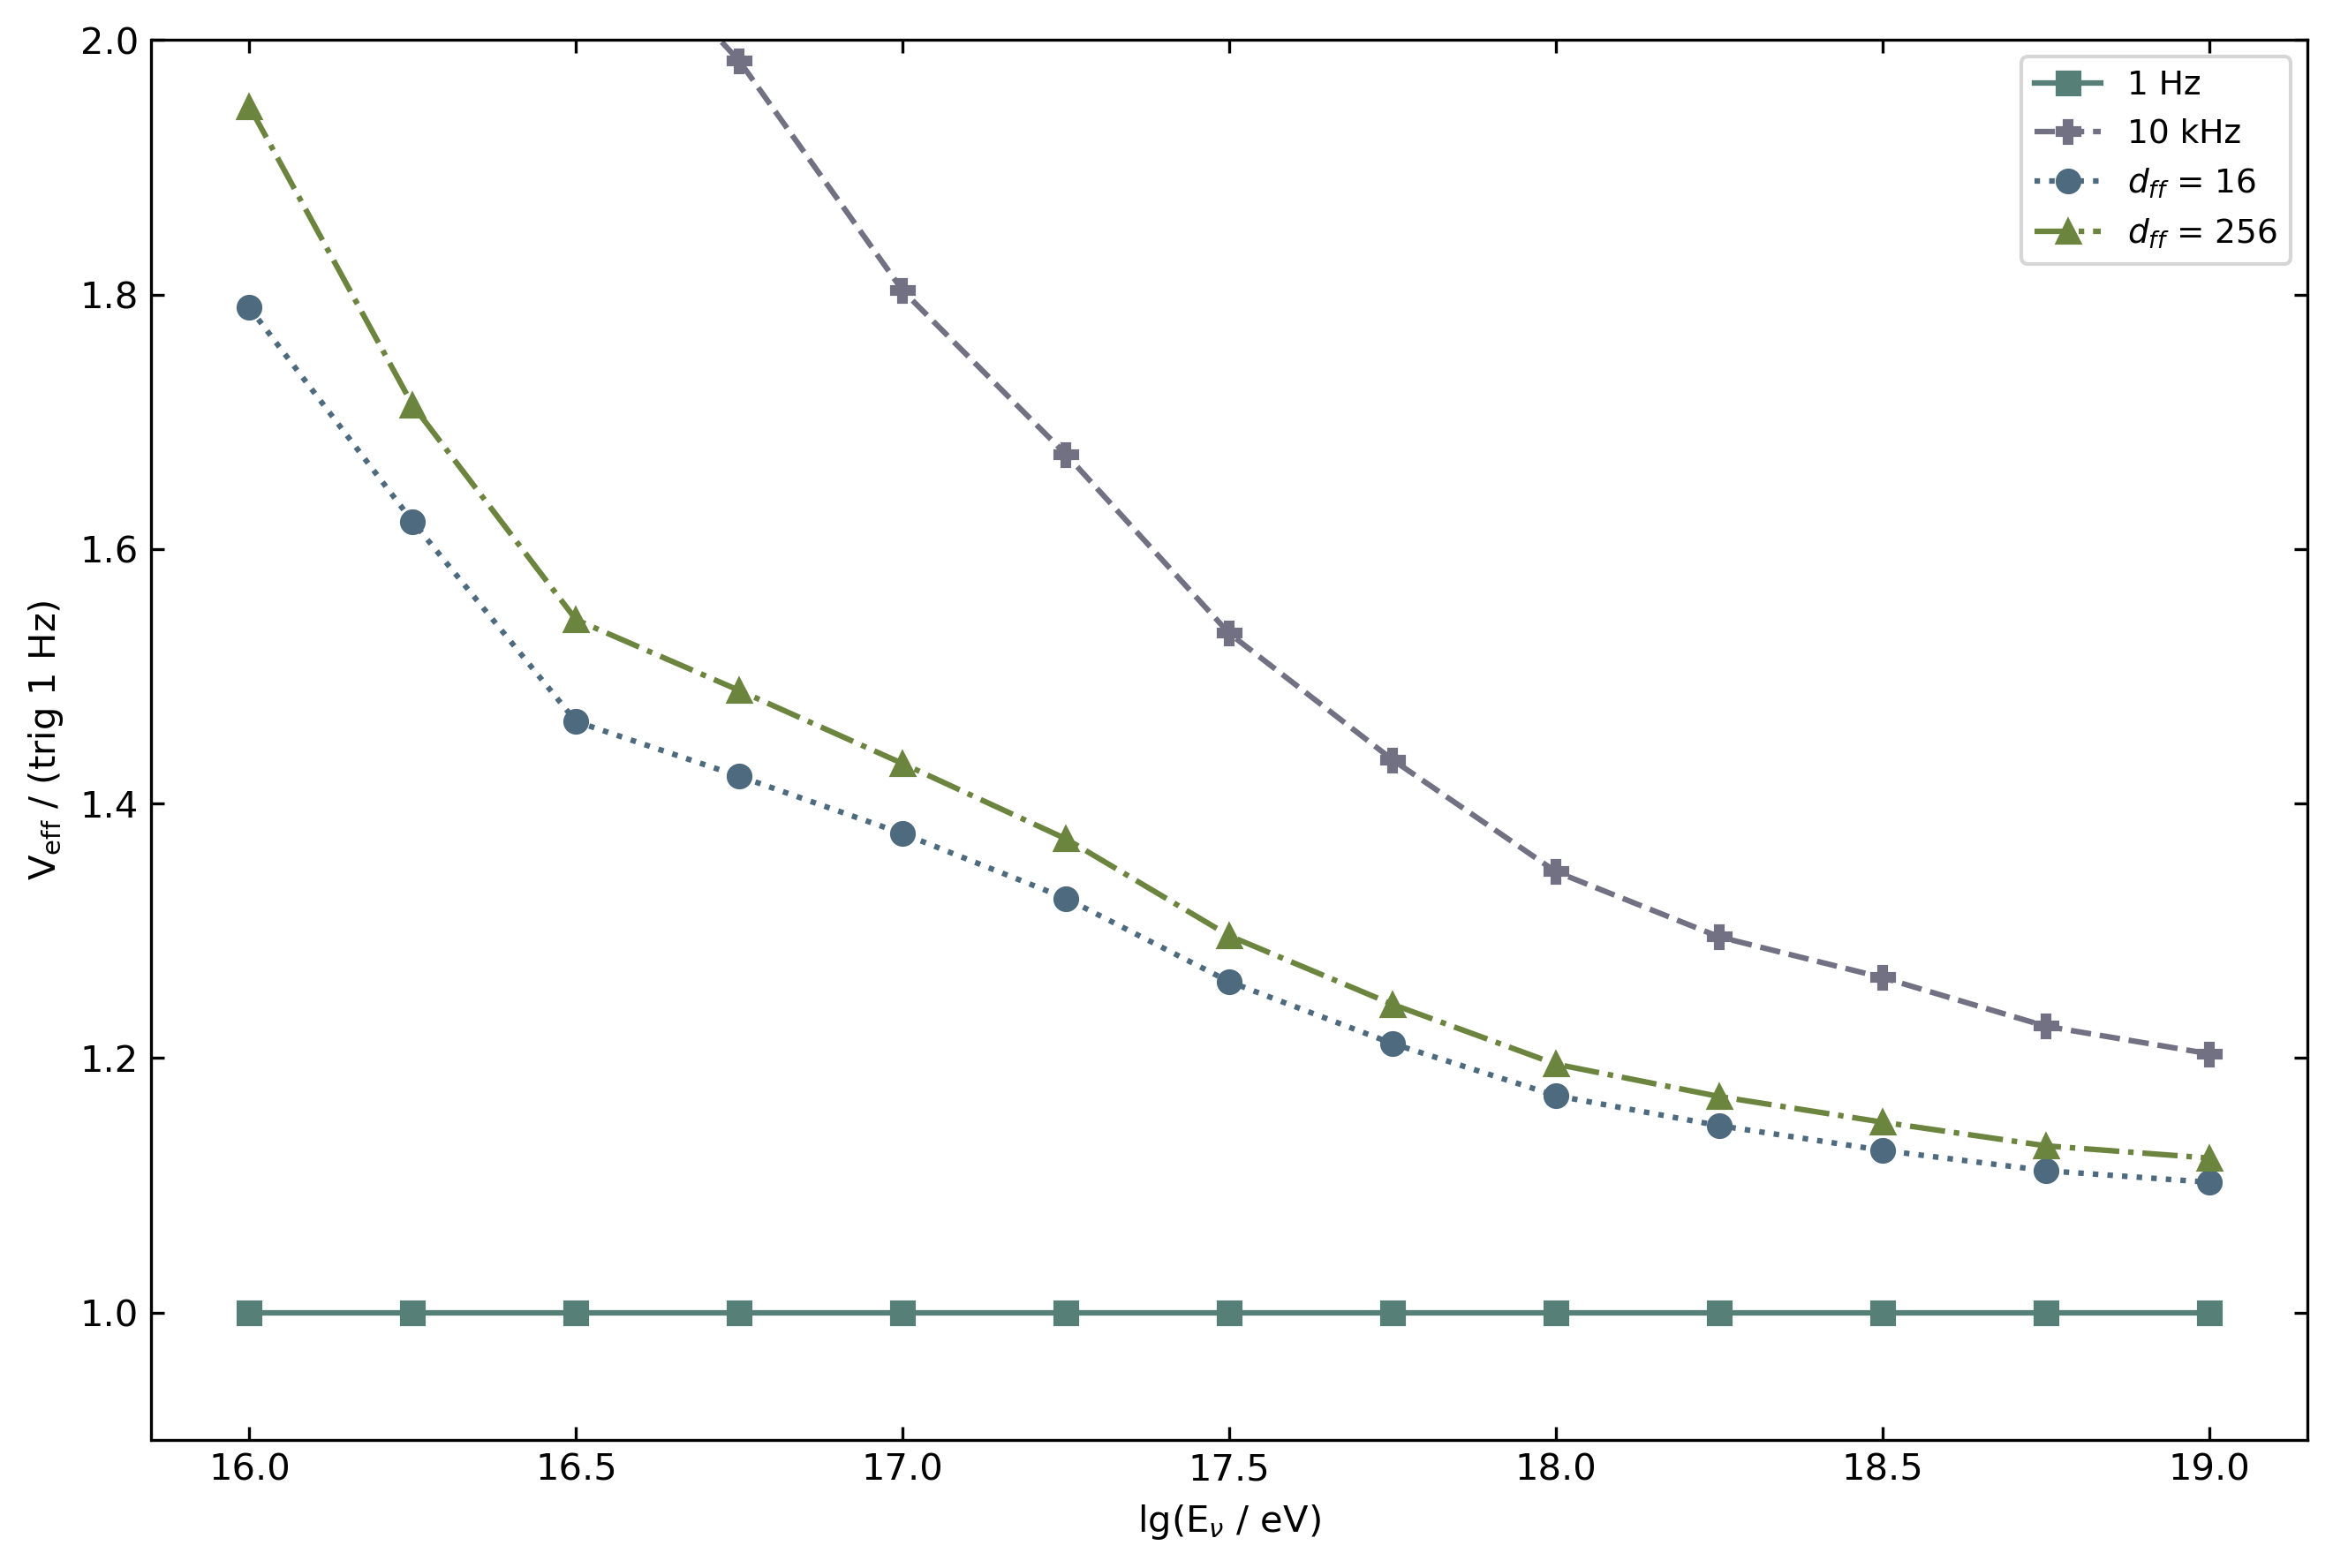

In [18]:
def rename_hyper_param(hyper_param):
    if hyper_param == 'd_model':
        return r'$d_{model}$'
    elif hyper_param == 'd_ff':
        return r'$d_{ff}$'
    elif hyper_param == 'h':
        return r'$h$'
    elif hyper_param == 'N':
        return r'$N$'
    elif hyper_param == 'pos_enc_type':
        return 'Pos. enc. type'
    elif hyper_param == 'embed_type':
        return 'Emb. type'
    elif hyper_param == 'max_pool':
        return 'Max pool'
    else:
        return hyper_param

def rename_hyper_param_values(hyper_param, value):
    if hyper_param == 'pos_enc_type':
        if value == 'Sinusoidal':
            return 'SPE'
        elif value == 'Learnable':
            return 'LPE'
        elif value == 'Relative':
            return 'RPE'
        else:
            return value
    elif hyper_param == 'embed_type':
        if value == 'ViT':
            return '2DCE'
        elif value == 'cnn':
            return 'CE' 
        elif value == 'linear':
            return 'LE'
        else:
            return value   
    else:
        return value   
    
hyper_param = 'd_ff'
y_max = 2
df_diff_copy_2 = df.copy()
uniqe_hyper_param_values = df_diff_copy_2[hyper_param].unique()
print(uniqe_hyper_param_values)
uniqe_hyper_param_values = np.sort(uniqe_hyper_param_values)
standard_triggers = ['1 Hz', '10 kHz']
grouped_results = results[results['Model'].isin(standard_triggers)]
for value in uniqe_hyper_param_values:
    sub_group = df_diff_copy_2[df_diff_copy_2[hyper_param] == value]
    models = list(map(str,sub_group['model_num'].values))
    sub_results = results[results['Model'].isin(models)]
    groupe_name = f"{rename_hyper_param(hyper_param)} = {rename_hyper_param_values(hyper_param,value)}"
    groupe_average = sub_results.mean().to_frame().T
    groupe_average['Model'] = groupe_name
    grouped_results = grouped_results.append(groupe_average)
def qualitative_colors(length, darkening_factor=0.6):
    colors = [cm.Set3(i) for i in np.linspace(0, 1, length)]
    darker_colors = [(r*darkening_factor, g*darkening_factor, b*darkening_factor, a) for r, g, b, a in colors]
    return darker_colors

colors = itertools.cycle(qualitative_colors(7))
markers = itertools.cycle(("s", "P", "o", "^", ">", "X"))
linestyles = itertools.cycle(("-", "--", ":", "dashdot", (0, (3, 5, 1, 5))))
nrows = 1
ncols = 1
fig, ax = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 15 * 0.7, nrows * 10 * 0.7), dpi=300, gridspec_kw={"wspace": 0.2, "hspace": 0.2}
)




grouped_results = grouped_results.set_index('Model')
grouped_results_droped_average = grouped_results.drop('Average', axis=1)
for index, row in grouped_results_droped_average.iterrows():
    label = 'Models: ' + index
    ax.plot(row, label=index, color=next(colors), marker=next(markers), linestyle=next(linestyles))
ax.legend(prop={"size": 9}, loc='upper right') # , bbox_to_anchor=(1.1, 1)
ax.set_xlabel(r"lg(E$_{\nu}$ / eV)")
ax.set_ylabel(r"V$_{\rm eff}$ / (" + 'trig 1 Hz' + ")")
ax.tick_params(axis="both", which="both", direction="in")
if y_max is not None:
    ax.set_ylim(0.9, y_max)
else: 
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0.9, ymax)
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
plt.show()

Mean: 1.3339675351473292
Std: 0.10085855571775935
Min: 1.137159722037384
Max: 1.4950059563469416
PDF value: 0.025509203270720843
0     500
1     501
2     502
3     503
4     504
5     505
6     506
7     507
8     508
9     509
10    510
11    511
12    512
13    513
14    514
15    515
16    516
17    517
18    518
19    519
Name: Model, dtype: object
0      500
1      501
2      502
3      503
4      504
5      505
6      506
7      507
8      508
9      509
10     510
11     511
12     512
13     513
14     514
15     515
16     516
17     517
18     518
19     519
20    Mean
Name: Model, dtype: object
   Model      16.0     16.25      16.5    16.75      17.0     17.25      17.5  \
0    500  1.736000  1.589000  1.431000  1.39900  1.355000  1.306000  1.245000   
1    501  1.756000  1.582000  1.433000  1.39800  1.360000  1.312000  1.247000   
2    502  1.796000  1.600000  1.454000  1.41700  1.370000  1.322000  1.259000   
3    503  1.793000  1.595000  1.457000  1.41700  1.371000  1.3

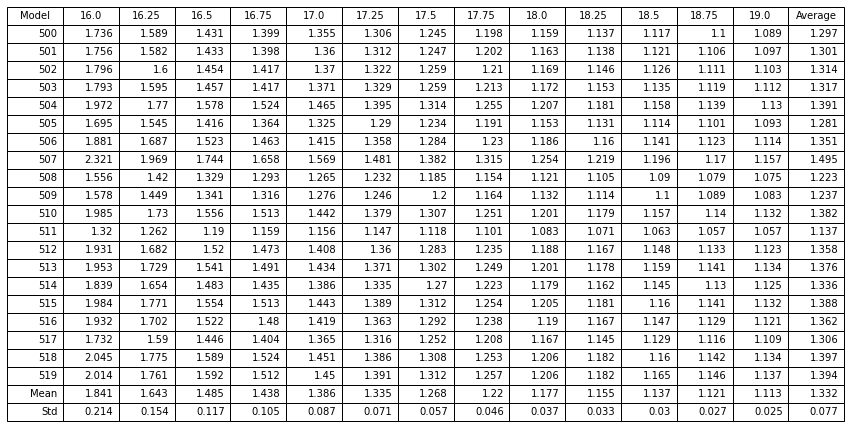

In [64]:
#excluding outliers
adjusted_values = values[values > min(values)]
adjusted_values = adjusted_values[adjusted_values < max(values)]
mean = np.mean(adjusted_values)
std = np.std(adjusted_values)*1.96
print(f"Mean: {mean}")
print(f"Std: {std}")
min_value = np.min(values)
max_value = np.max(values)
cdf_value = norm.cdf(min_value, loc=mean, scale=std)
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"PDF value: {cdf_value}")

# Calculate the mean of each column (excluding 'Model')
mean_row = model_results.drop('Model', axis=1).mean()

# Calculate the standard deviation of each column (excluding 'Model')
std_row = model_results.drop('Model', axis=1).std()

new_results = model_results.reset_index(drop=True)
print(new_results['Model'])
# Add the mean and standard deviation rows to the DataFrame
new_results.loc[len(new_results)] = ['Mean'] + list(mean_row)
print(new_results['Model'])
new_results = new_results.round(3)

new_results.loc[len(new_results)] = ['Std'] + list(std_row)
print(new_results)
new_results = new_results.round(3)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Hide axes
ax.axis('off')

# Create table and display it
table = plt.table(cellText=new_results.values, colLabels=new_results.columns, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.show()


Plot collections of noise reduction factors or roc curve

/software/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


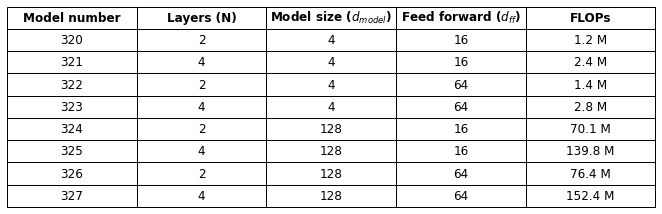

   model_num  N  d_model  d_ff      FLOPs
0        320  2        4    16    1181709
0        321  4        4    16    2353165
0        322  2        4    64    1402893
0        323  4        4    64    2795533
0        324  2      128    16   70066561
0        325  4      128    16  139805057
0        326  2      128    64   76382593
0        327  4      128    64  152437121


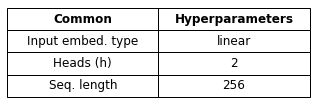

In [6]:

# models = [310,311,312,313,314,315]
model_path =  '/home/halin/Master/nuradio-analysis/configs/chunked/'
models = list(range(320,328))
evaluate = False
#models = [301,302,303,311]

df = collect_config_to_df(models, model_path=model_path, type_of_file='yaml')
if evaluate:
    df['Veff avg.'] = values

sort = False
col_width = 3.0
save = False
prefix = ''
compare_keys = ['batch_size']
compare_df = df[compare_keys]
df_same, df_diff = get_same_diff_df(df)

exclude_columns = [
    # 'activation',
    #'batch_size',
    # 'decreas_factor',
    # 'dropout',
    # #'embed_type',
    #'NSE_AT_10KNRF',
    'encoder_param',
    'num_param',
    # 'encoder_type',
    'final_param',
    # #'final_type',
    'input_param',
    # 'learning_rate',
    # 'location',
    # 'loss_function',
    'max_relative_position',
    # 'n_ant',
    # 'normalization',
    # #'pos_enc_type',
    'pos_param',
    # 'residual_type',
    # 'seq_len',
    # 'step_size',
    # 'encode_type',
    'training_time',
    'MACs'

]
if df_diff.empty:
    print('No common values')
    plot_comparing_models(df_same.iloc[[0]], 
                          row_height=0.35, 
                          col_width=col_width, 
                          sort=sort, 
                          exclude_columns=exclude_columns, 
                          save=save,
                          prefix=prefix
                          )
    exclude_columns = [
        'N',
        'MACs',
        'NSE_AT_10KNRF',
        'activation',
        'd_ff',
        'd_model',
        'embed_type',
        'encoder_param',
        'encoder_type',
        'final_param',
        'final_type',
        'h',
        'input_param',
        'location',
        
        'max_relative_position',
        'model_num',
        'n_ant',
        'normalization',
        'num_param',
        #'pos_enc_type',
        'pos_param',
        'residual_type',
        'encode_type',
        'training_time',
    ]
    plot_common(df_same.iloc[[0]] , 
                row_height=0.4, 
                col_width=col_width+0.5, 
                exclude_columns=exclude_columns, 
                save=save,
                prefix=prefix,
                )
else:
    df = plot_comparing_models(df_diff, 
                          row_height=0.35, 
                          col_width=col_width, 
                          sort=sort, 
                          exclude_columns=exclude_columns, 
                          save=save,
                          prefix=prefix,
                          )
    print(df)
    categorical_values = ['Pos. enc. type', 'Act. function', 'Input embed. type', 'Loss function', 'Projection type']
    if evaluate:
        chi_square_tests(df, 'Veff avg.')
        correlation = df.corr()['Veff avg.']
        print(correlation)  
    exclude_columns = [
    'activation',
    'batch_size',
    'decreas_factor',
    'dropout',
    #'embed_type',
    'encoder_param',
    'encoder_type',
    'final_param',
    'final_type',
    'input_param',
    'num_param',
    'learning_rate',
    'location',
    'loss_function',
    'max_relative_position',
    'n_ant',
    'normalization',
    'pos_enc_type',
    'pos_param',
    'residual_type',
    # 'seq_len',
    'step_size',
    'encode_type',
    'training_time',
    'MACs',
    'NSE_AT_10KNRF',
    'max_pool',
    'FLOP',
    'step_size',
    'learning_rate',
    'projection_type',

]
    plot_common(df_same.iloc[[0]] , 
                row_height=0.4, 
                col_width=col_width + 0.5, 
                exclude_columns=exclude_columns, 
                save=save,
                prefix=prefix,
                )
# show_plots(model_num=200, search_string='roc')   

In [ ]:
# Group by 'd_model', 'd_ff', and 'h' and convert each group to a list of 'model_num'
grouped = df.groupby(['d_model', 'd_ff', 'h'])['model_num'].apply(list)

# Convert the grouped Series to a list of lists
model_groups = grouped.tolist()

print(model_groups)

In [ ]:
correlation = df.corr()['Veff avg.']
print(correlation)  
sub_df = df[df['d_model'] == 8]
sub_df_1 = plot_comparing_models(df=sub_df, 
                          row_height=0.35, 
                          col_width=col_width, 
                          sort=sort, 
                          exclude_columns=exclude_columns, 
                          save=save,
                          prefix=prefix,
                          )

In [ ]:
# Assuming 'df' is your DataFrame and 'model' is the column containing the model names
new_results_2 = new_results.copy()
# Create a list of all the models that have N=2
models_N2 = df[df['N'] == 2]['model_num'].tolist()

# Create a list of all the models that have N=3
models_N3 = df[df['N'] == 3]['model_num'].tolist()
# Calculate the average value over models_N2 for each energy bin
# Print unique models in 'Model' column
# Convert elements in models_N2 and models_N3 to strings
models_N2 = [str(model) for model in models_N2]
models_N3 = [str(model) for model in models_N3]
# Get the column names
column_names = new_results.columns.tolist()

# Remove 'Model' and 'Average' from the list
column_names.remove('Model')
column_names.remove('Average')

# Filter the DataFrame
filtered_df = new_results[new_results['Model'].isin(models_N2)]


# Calculate the average value over models_N2 for each energy bin
average_N2 = filtered_df[column_names].mean()

# Add the average_N2 as a new row to the DataFrame
new_results_2.loc[len(new_results_2)] = ['Average N2'] + list(average_N2) + [np.mean(average_N2)]

# Calculate the average value over models_N3 for each energy bin
# Repeat the process for models_N3
filtered_df = new_results[new_results['Model'].isin(models_N3)]
average_N3 = filtered_df[column_names].mean()
# Add the average_N3 as a new row to the DataFrame
new_results_2.loc[len(new_results_2)] = ['Average N3'] + list(average_N3) + [np.mean(average_N3)]

print(new_results_2)

In [ ]:
dic = {'N': [2,3], 'd_model': [8,32]}
for key, value in dic.items():
    for v in value:
        sub_df = df[df[key] == v]

        x = sub_df[['N', 'd_model', 'h', 'd_ff']]
        y = sub_df['Veff avg.']

        # Scale the features
        scaler = StandardScaler()
        x_scaled = scaler.fit_transform(x)

        x = sm.add_constant(x)

        model = sm.OLS(y, x).fit()

        print(f"Key: {key}, Value: {value},P-value: N = {model.pvalues['N']:.2f}, d_model = {model.pvalues['d_model']:.2f}, h = {model.pvalues['h']:.2f}, d_ff = {model.pvalues['d_ff']:.2f}")